In [1]:
import os
import random
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms

import seaborn as sns
from sklearn.metrics import confusion_matrix

from model import mini_Xception
from trainer import Drive_Trainer


In [2]:
root = os.path.join(os.getcwd())
root

'/Users/youngsun/Desktop/socar-hackathon'

# Sample Image

In [3]:
def sample_img(scenario):
    
    if scenario in ['01', '08', '15', '20']:
        label = 'normal'
        sup_label = 'Normal'
        if scenario in ['01', '20']:
            scene_name = 'Normal'
        elif scenario == '08':
            scene_name = 'Glasses Normal'
        else:
            scene_name = 'Cap Normal'
    elif scenario in ['02', '09', '16', '21']:
        label = "drowsy"
        sup_label = 'Drowsy'
        if scenario in ['02', '21']:
            scene_name = 'Drowsy'
        elif scenario == '09':
            scene_name = 'Glasses Drowsy'
        else:
            scene_name = 'Cap Drowsy'
    elif scenario in ['03', '10', '17', '22']:
        label = 'drowsy'
        sup_label = 'Drowsy'
        if scenario in ['03', '22']:
            scene_name = 'Yawn'
        elif scenario == '10':
            scene_name = 'Glasses Yawn'
        else:
            scene_name = 'Cap Yawn'
    elif scenario in ['05', '12', '19']:
        label = 'call'
        sup_label = 'Careless'
        if scenario == '05':
            scene_name = 'Call'
        elif scenario == '12':
            scene_name = 'Glasses Call'
        else:
            scene_name = 'Cap Call'
    elif scenario in ['07', '14']:
        label = 'tobacco'
        sup_label = 'Careless'
        if scenario == '07':
            scene_name = 'Tobacco'
        else:
            scene_name = 'Glasses Tobacco'       
    else:
        return False
    
    img_names = os.listdir(os.path.join(root, f'drive_face/train/{label}/{scenario}'))
    if '.DS_Store' in img_names:
        img_names.remove('.DS_Store')
    idx = random.Random(2002).randint(0, len(img_names))
    img_name = img_names[idx]
            
    sample_img_path = list((f'{root}/drive_face/train/{label}/{scenario}/{img_name}', scene_name, sup_label))
    return sample_img_path

scenarios = ['01', '08', '15', '20', '02', '09', '16', '21', '03', '10', '17', '22', '05', '12', '19', '07', '14']
sample_list = []
for scenario in scenarios:
    sample_list.append(sample_img(scenario))

def plot_image(img_list, figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    n = len(img_list)
    if n <= 5:
        for i in range(n):
            img = Image.open(img_list[i][0])
            ax = fig.add_subplot(1, n, i+1)
            ax.imshow(img)
            ax.set_title(f'Scene name: {img_list[i][1]}')
            plt.axis('off')
    else:
        for i in range(n):
            img = Image.open(img_list[i][0])
            ax = fig.add_subplot(2, 4, i+1)
            ax.imshow(img)
            ax.set_title(f'Scene name: {img_list[i][1]}')
            plt.axis('off')
    fig.suptitle(f'Label: {img_list[i][2]}')

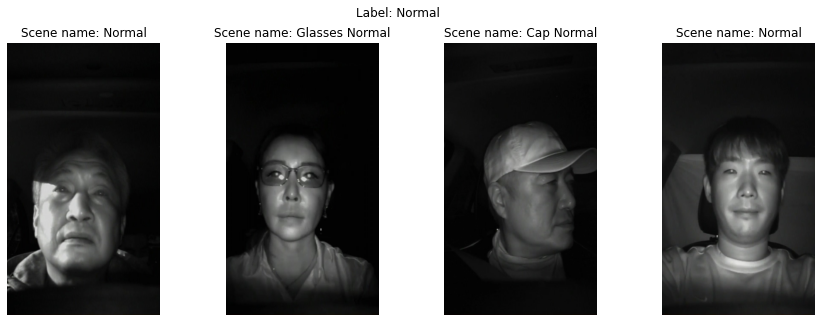

In [4]:
plot_image(sample_list[0:4], (15,5))

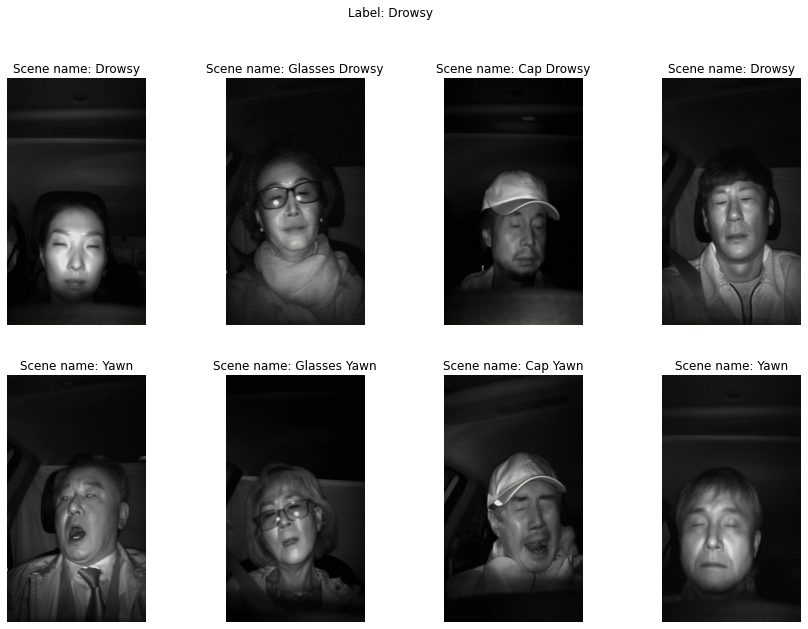

In [5]:
plot_image(sample_list[4:12], (15,10))

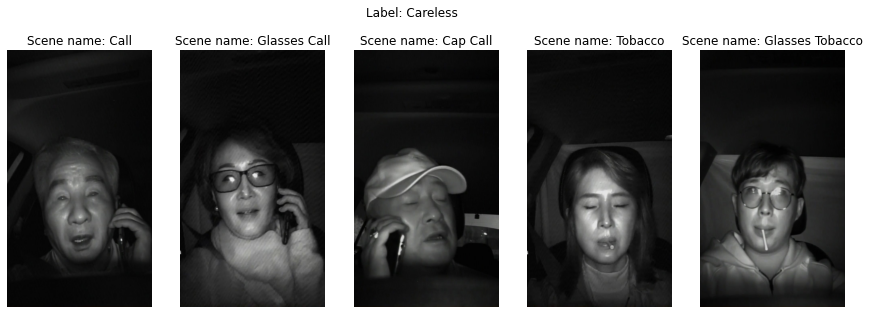

In [6]:
plot_image(sample_list[12:], (15,5))

orginal shape: (1280, 720, 3)
transformed shape: (224, 224, 3) and we are going to use only one channel.


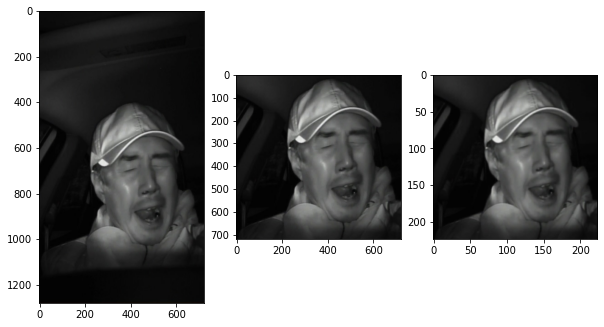

In [7]:
sample = Image.open(sample_list[10][0])
np_sample = np.array(sample)[200:]
sample_r = Image.fromarray(np_sample)
sample1 = transforms.CenterCrop((720))(sample_r)
sample2 = transforms.Resize((224))(sample1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1)
ax.imshow(sample)
ax = fig.add_subplot(1,3,2)
ax.imshow(sample1)
ax = fig.add_subplot(1,3,3)
ax.imshow(sample2);

np_sample = np.array(sample)
np_sample2 = np.array(sample2)
print(f"orginal shape: {np_sample.shape}")
print(f"transformed shape: {np_sample2.shape} and we are going to use only one channel.")

# Load Data

In [8]:
from dataset import *

start_time = time.time()
drive_train = DRIVE_Dataset(os.path.join(root, 'drive_face/train'), get_transform(train=True))
drive_valid = DRIVE_Dataset(os.path.join(root, 'drive_face/valid'), get_transform(train=False))
drive_test = DRIVE_Dataset(os.path.join(root, 'drive_face/test'), get_transform(train=False))
b = 64
train_loader = DataLoader(drive_train, batch_size=b, shuffle=True, drop_last=True)
valid_loader = DataLoader(drive_valid, batch_size=b, shuffle=False, drop_last=True)
test_loader = DataLoader(drive_test, batch_size=b, shuffle=False, drop_last=True)

print(f"Data Load Success, time: {time.time()-start_time:>3f}")
print("trainset size:", len(drive_train))
print("validationset size:", len(drive_valid))
print("testset size:", len(drive_test))
print(f"batch size: {b}")
print("# of train batch:", len(train_loader))
print("# of valid batch:", len(valid_loader))
print("# of test batch:", len(test_loader))

Data Load Success, time: 0.098068
trainset size: 23244
validationset size: 3490
testset size: 3229
batch size: 64
# of train batch: 363
# of valid batch: 54
# of test batch: 50


In [9]:
drive_train[0][0].shape

torch.Size([1, 224, 224])

# Dataset Split Proportion

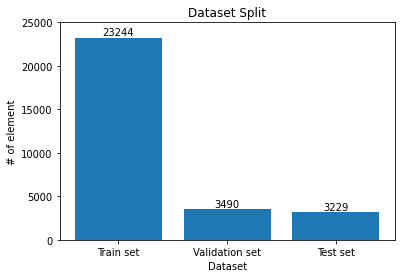

In [10]:
x = ["Train set", "Validation set", "Test set"]
y = [len(drive_train), len(drive_valid), len(drive_test)]
def add_value_label(x ,y):
    for i in range(0, len(x)):
        plt.text(i, y[i], y[i], ha='center', va='bottom')
plt.bar(x, y)
add_value_label(x, y)
plt.ylim(0, 25000)
plt.title("Dataset Split")
plt.xlabel("Dataset")
plt.ylabel("# of element")
plt.show();

# Label Distribution

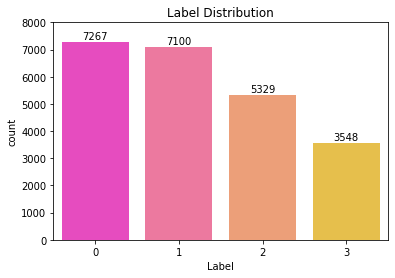

In [11]:
Label_list = [drive_train[i][1] for i in range(len(drive_train))]
ax = sns.countplot(x = Label_list, palette='spring')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', va='bottom')
ax.set_ylim(0, 8000)
ax.set_xlabel("Label")
ax.set_title("Label Distribution");

# Our Classification Model

In [12]:
checkpoint_path = "./classification_model/mini_xception_log_epoch_best1.pth"
checkpoint = torch.load(checkpoint_path)
classifier = mini_Xception(n_class=4)
classifier.load_state_dict(checkpoint["model_state_dict"])
classifier.eval()

mini_Xception(
  (start_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (blocks): ModuleList(
    (0): Block(
      (residual_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (residual_bnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (DSC_1): Depthwise_Separable_Conv(
        (depthwise): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=8, bias=False)
        (pointwise): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (DSC_batch_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (DSC_activation_1): ReLU()
      (DSC_2): Dept

# Train Result

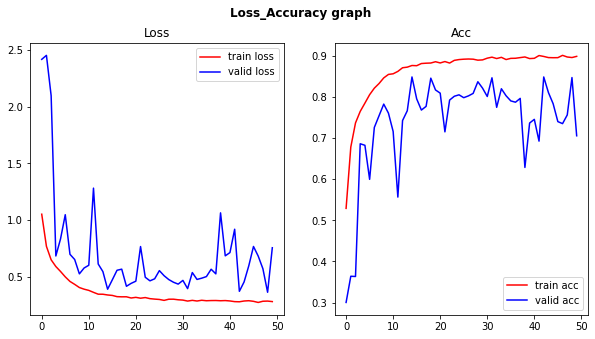

In [13]:
img1 = Image.open('./graphics/mini_xception_graph_epoch_49.png')
img1

# Best Model

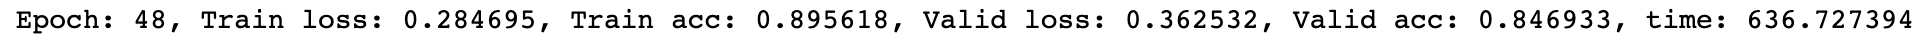

In [14]:
img2 = Image.open('./graphics/loss_acc_48.png')
img2

# Testset & Confusion Matrix

In [15]:
# testset, confusion matrix
device="mps"
trainer_load = Drive_Trainer(model=classifier, opt='adam', lr=0.001, has_scheduler=False, device=device).to(device)
trainer_load.test(test_loader)

==== Test Start ====
Iter: 10/50, test epoch loss: 0.428183, test epoch acc: 0.831250, time: 10.638838
Iter: 20/50, test epoch loss: 0.409740, test epoch acc: 0.841406, time: 7.987678
Iter: 30/50, test epoch loss: 0.399176, test epoch acc: 0.841667, time: 7.989755
Iter: 40/50, test epoch loss: 0.397717, test epoch acc: 0.842187, time: 7.919894
Iter: 50/50, test epoch loss: 0.398256, test epoch acc: 0.845000, time: 8.016123
Test loss: 0.398256, Test acc: 0.845000, time: 42.571514
--------------------------------------------------------




In [16]:
def get_cm(network, testset):
    y_pred = []
    y_true = []
    device='mps'
    loader = DataLoader(testset, batch_size=1, shuffle=False)
    network.eval()
    with torch.no_grad():
          for (x, y) in loader:
                x = x.to(device)
                y_hat = network(x).argmax(dim=1).cpu().numpy()
                y_pred.append(y_hat)
                
                y = y.data.cpu().numpy()
                y_true.append(y)
    
    cm = confusion_matrix(y_true, y_pred)
    return(cm)

cm = get_cm(classifier, drive_test)

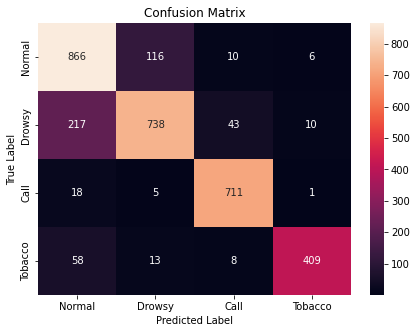

In [17]:
LABEL=["Normal", "Drowsy", "Call", "Tobacco"]
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABEL, yticklabels=LABEL)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show();

# Transform & Inference

In [18]:
emotions = {0: "Normal", 1: "Drowsy", 2: "Call", 3: "Tobacco"}


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

def inference_transform():
    transform_list = [transforms.ToTensor(),
                      transforms.CenterCrop((720)),
                      transforms.Resize((224)),
                      transforms.Normalize((0.5, ), (0.5, ))]
    return Compose(transform_list)

def convert_img2tensor(img):
    #img = np.array(img)
    img_tensor = inference_transform()(img)
    img_tensor = img_tensor.view(-1,1,224,224)
    return img_tensor

def inference(model, img):
    img_tensor = convert_img2tensor(img)
    result = model(img_tensor).argmax(dim=1).item()
    return emotions[result]

# Model Inference

In [19]:
"""
data root만 본인 경로에 맞게 지정
"""
data_root = os.path.join(os.getcwd(), "drive_face")

# Test image data path
test_normal_data = os.path.join(data_root, "test", "normal")
test_drowsy_data = os.path.join(data_root, "test", "drowsy")
test_call_data = os.path.join(data_root, "test", "call")
test_tobacco_data = os.path.join(data_root, "test", "tobacco")


def random_choice_img_file(path):
    """
    image class 별로 random하게 image 데이터 추출(여백 제거)
    Returns: image data list
    """
    image_list = []
    folders = [f for f in random.sample(os.listdir(path), len(os.listdir(path))) if not f.startswith('.')]
    for folder in folders:
        img_files = [f for f in random.sample(os.listdir(f"{path}/{folder}"), 20) if not f.startswith('.')]
        for img_file in img_files:
            img_file_path = f"{path}/{folder}/{img_file}"
            image = Image.open(img_file_path)
            # 공백 제거
            sample = np.array(image)
            sample = sample[200:]
            image = Image.fromarray(sample)
            image_list.append(image)
        
    return image_list


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


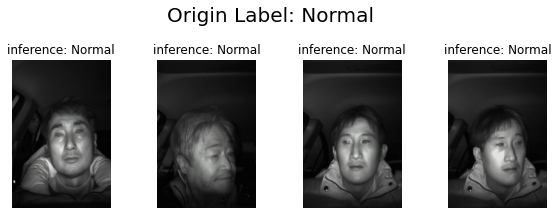

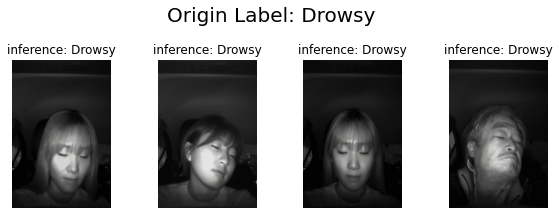

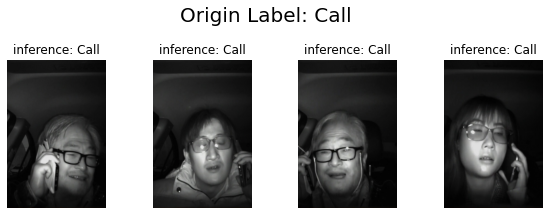

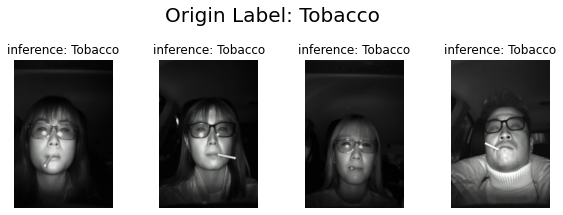

In [20]:
normal_image_list = random_choice_img_file(test_normal_data)
drowsy_image_list = random_choice_img_file(test_drowsy_data)
call_image_list = random_choice_img_file(test_call_data)
tobacco_image_list = random_choice_img_file(test_tobacco_data)

def plot_image(data, origin_label, figsize=(10, 6)):
    """
    inference 결과 조회
    random 으로 조회하여 class 별로 inference가 맞는 최대 MAX_NUM 개 선정
    """
    MAX_NUM = 4
    fig = plt.figure(figsize=figsize)
    plot_index = 0
    for i in range(len(data)):
        img = data[i][0]
        # set title
        result = data[i][1]
        fig.suptitle(f"Origin Label: {origin_label}", fontsize=20, verticalalignment="center")
        if result == origin_label:
            if plot_index < MAX_NUM:
                ax = fig.add_subplot(2, 4, plot_index+1)
                ax.imshow(img)
                ax.set_title(f"inference: {result}")
                plot_index += 1
                plt.axis('off')
            else:
                break

    
def make_inference_result(image_list):
    """
    inference 결과를 저장
    """

    for index, image in enumerate(image_list):
        # model inference
        result = inference(classifier, image.convert("L"))
        image_list[index] = (image, result)
    
classifier.to("cpu")

# normal
make_inference_result(normal_image_list)
plot_image(normal_image_list, "Normal")

# drowsy
make_inference_result(drowsy_image_list)
plot_image(drowsy_image_list, "Drowsy")

# call
make_inference_result(call_image_list)
plot_image(call_image_list, "Call")

# tobacco
make_inference_result(tobacco_image_list)
plot_image(tobacco_image_list, "Tobacco")
